In [305]:
import pandas as pd
import seaborn as sns
from  matplotlib import pyplot as plt, ticker, patches
import numpy as np
from scipy.interpolate import Rbf
from datetime import date, timedelta

In [287]:
# For high pixel-density screens, e.g. retina, only
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# Make figures bigger
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7
sns.set(style="darkgrid")

In [288]:
url = "https://raw.githubusercontent.com/datasets/covid-19/master/time-series-19-covid-combined.csv"
data = pd.read_csv(url).set_index(['Country/Region', 'Province/State', 'Date']).sort_index()
data.loc[('US', 'Washington')][-10:] # Show last ten rows from Washington, US

,Lat,Long,Confirmed,Recovered,Deaths
Date,,,,,
2020-03-11,47.4009,-121.4905,366,1,29
2020-03-12,47.4009,-121.4905,442,1,31
2020-03-13,47.4009,-121.4905,568,1,37
2020-03-14,47.4009,-121.4905,572,1,37
2020-03-15,47.4009,-121.4905,643,1,40
2020-03-16,47.4009,-121.4905,904,1,48
2020-03-17,47.4009,-121.4905,1076,1,55
2020-03-18,47.4009,-121.4905,1014,0,55
2020-03-19,47.4009,-121.4905,1376,0,74


In [289]:
url = "https://covid.ourworldindata.org/data/ecdc/full_data.csv"
data = pd.read_csv(url).set_index(["location", "date"]).sort_index()
data.loc["United Kingdom"]

,new_cases,new_deaths,total_cases,total_deaths
date,,,,
2019-12-31,0,0,0,0
2020-01-01,0,0,0,0
2020-01-02,0,0,0,0
2020-01-03,0,0,0,0
2020-01-04,0,0,0,0
...,...,...,...,...
2020-03-17,152,20,1543,55
2020-03-18,407,5,1950,60
2020-03-19,680,43,2630,103


In [348]:
(166/255.0, 191/255.0, 216/255.0)

(0.6509803921568628, 0.7490196078431373, 0.8470588235294118)

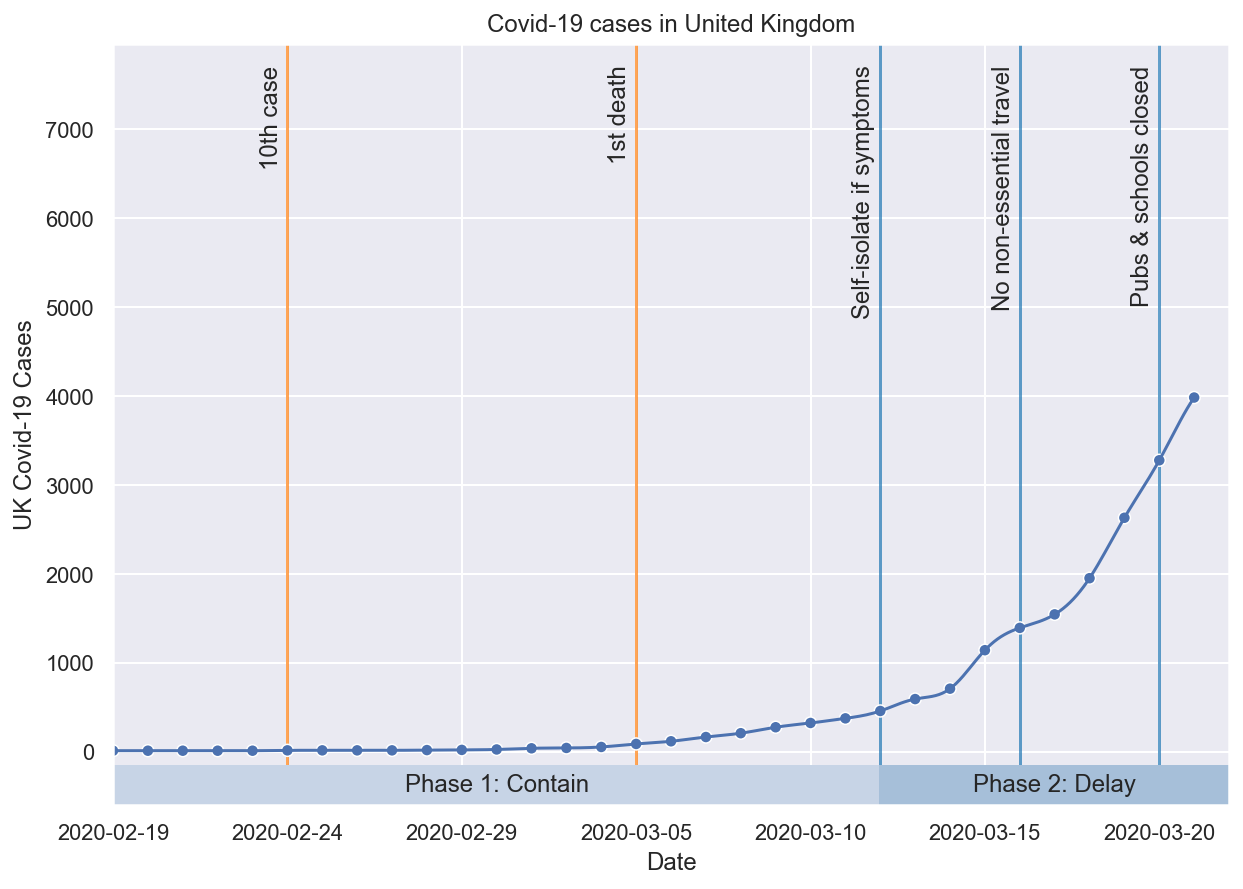

In [378]:
def plot_timeline(df, metadata, start_date):
    y = df.to_numpy()
    x = np.linspace(0, len(df)-1, len(df))
    rbf = Rbf(x, y)
    x_interpolate = np.linspace(0, len(df) -1, len(df) * 10)
    y_interpolate = rbf(x_interpolate)
    y_interpolate[y_interpolate < 0] = 0
     
    event_colors = {
        "case": "tab:orange",
        "death": "tab:red",
        "policy": "tab:blue"
    }
    
    phase_colors = {
        "contain": (0.78, 0.83, 0.90),
        "delay": (0.65, 0.75, 0.85),
    }
    
    plot_ceil = max(y)*2.0
    plot_floor = max(y)*-0.15
    data_start_date = pd.to_datetime(df.index[0]).date()
    data_end_date = pd.to_datetime(df.index[-1]).date()
    plot_start = (start_date - data_start_date).days
    plot_end = len(df)
    plot_width = plot_end - plot_start

    # Set plot width and height
    plt.ylim(plot_floor, plot_ceil)
    plt.xlim(plot_start, plot_end)
    
    # Get the current reference
    ax = plt.gca()
    
    # Plot phases
    for i, phase in enumerate(metadata['phases']):
        start = phase['from'] if (phase['from'] > start_date) else start_date
        end = phase['to'] if (phase['to'] < data_end_date) else data_end_date + timedelta(days=1)
        start_x = (start - start_date).days + plot_start
        start_y = -plot_ceil*0.02
        width = (end - start_date).days + plot_start - start_x
        color = phase_colors[phase['type']]
        rect = patches.Rectangle((start_x, start_y), width, -100000, edgecolor=color, facecolor=color, zorder=0.8)
        ax.add_patch(rect)
        label = "Phase {}: {}".format(i+1, phase['type'].title())
        plt.text(start_x + width/2.0, -plot_ceil*0.03, label, verticalalignment='top', horizontalalignment='center')
    
    # Plot events
    for i, event in enumerate(metadata['events']):
        days = (event['date'] - start_date).days + plot_start
        plt.axvline(days, 0, 1, color=event_colors[event['type']], alpha=0.7, zorder=0.7)
        plt.text(days-plot_width*0.025, plot_ceil*0.97, event['label'], rotation=90, verticalalignment='top')
    
    # Plot extrapolated curve
    ax = sns.lineplot(y=y_interpolate, x=x_interpolate, ax=ax, legend=False)
    
    # Plot discs for actual data points
    sns.scatterplot(data=pd.DataFrame(y, x), ax=ax, legend=False)
    
    # Make x-axis have dates
    fmt = ticker.FuncFormatter(lambda x, pos: data_start_date + timedelta(days=x))
    ax.xaxis.set_major_formatter(fmt)
    
    # Set title and labels
    plt.title("Covid-19 cases in {}".format(metadata['country']))
    ax.set_xlabel("Date")
    ax.set_ylabel("{} Covid-19 Cases".format(metadata['country_code']))

uk_metadata = {
    "country": "United Kingdom",
    "country_code": "UK",
    "events": [
        {"type": "case", "label": "10th case", "date": date(2020, 2, 24), "source": "https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_the_United_Kingdom"},
        {"type": "case", "label": "1st death", "date": date(2020, 3, 5), "source": "https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_the_United_Kingdom"},
        {"type": "policy", "label": "Self-isolate if symptoms", "date": date(2020, 3, 12), "source": "https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_the_United_Kingdom"},
        {"type": "policy", "label": "No non-essential travel", "date": date(2020, 3, 16), "source": "https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_the_United_Kingdom"},
        {"type": "policy", "label": "Pubs & schools closed", "date": date(2020, 3, 20), "source": "https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_the_United_Kingdom"}
    ],
    "phases": [
        {"type": "contain", "from": date(2020, 1, 1), "to": date(2020, 3, 12), "source": "https://www.theguardian.com/world/2020/mar/12/uk-moves-to-delay-phase-of-coronavirus-plan" },
        {"type": "delay", "from": date(2020, 3, 12), "to": date(2020, 12, 31), "source": "https://www.theguardian.com/world/2020/mar/12/uk-moves-to-delay-phase-of-coronavirus-plan" }
    ]
}
plot_timeline(data.loc['United Kingdom']['total_cases'], uk_metadata, date(2020, 2, 19))

In [218]:
# TODO
# v Gather data for country's testing methodoligies
# v Insert horizontal bars marking the testing methodology
# - Have policy changes be different saturations of blue
# - Create side-plots with daily cases and death rate with same bars but without text
# - Play with having death rate shown on same plot
# - Get data on time from infection to hospitalisation
# - Get data on time from infectino to death
# - Show dotted line when we expect the effect of a policy change to start showing

,date,new_cases,new_deaths,total_cases,total_deaths
location,,,,,
Afghanistan,2019-12-31,0,0,0,0
Afghanistan,2020-01-01,0,0,0,0
Afghanistan,2020-01-02,0,0,0,0
Afghanistan,2020-01-03,0,0,0,0
Afghanistan,2020-01-04,0,0,0,0
...,...,...,...,...,...
World,2020-03-18,14750,770,194909,7873
World,2020-03-19,18345,970,213254,8843
World,2020-03-20,29222,1042,242476,9885


In [207]:
blah = pd.DataFrame([1,2,4,8,16,32,64,128,256,512]).rolling(3, center=True).mean()
ones = pd.DataFrame(np.ones(10)).rolling(3, min_periods=1, center=True).sum()
blah

,0
0,NaN
1,2.333333
2,4.666667
3,9.333333
4,18.666667
5,37.333333
6,74.666667
7,149.333333
8,298.666667
9,NaN
